In [7]:
import yt_dlp
import cv2
from urllib.parse import urlparse
from urllib.parse import parse_qs
import glob

import torch

import fiftyone as fo
from fiftyone import ViewField as F
import fiftyone.utils.random as four

import pandas as pd

from matplotlib import pyplot as plt

In [8]:
%matplotlib inline

In [3]:
# 1. Збір даних

# Створити список посилань на відео
video_urls = [
    # cars
    "https://www.youtube.com/watch?v=MNn9qKG2UFI",
    
    # people
    "https://www.youtube.com/watch?v=8qfdGBNoqBc",
    "https://www.youtube.com/watch?v=NyLF8nHIquM",
    
    # pets
    "https://www.youtube.com/watch?v=w8WdogrgkAU",
    "https://www.youtube.com/watch?v=czoArYpSCMI",
    "https://www.youtube.com/watch?v=ZdwzExyUY9k"
]

In [ ]:
with yt_dlp.YoutubeDL({
    "outtmpl": "data/videos/%(autonumber)s [%(id)s] %(title)s.%(ext)s",
    "format":"135", #480p
    #"format":"136", #720p #'best'
    "progress_hooks": [lambda d: print(f"{d['status']}%")],
    "quiet": True  # Suppress download info, except progress
    }) as ydlp:
    ydlp.download(video_urls)

In [44]:
for i, url in enumerate(video_urls):
    video_id = parse_qs(urlparse(url).query)['v'][0]
    video_path = [item for item in glob.glob("data/videos/*") if f"[{video_id}]" in item][0]
    print(f"\n{i+1} {video_id}")
    
    # Розбити відео на фрейми
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    skipNoFrames = max(fps, -(totalNoFrames // -(5000))) # up to 5k frames

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % skipNoFrames == 0:    
            # Зберегти кадр
            cv2.imwrite(f"data/frames/{i+1:05} [{video_id}] {frame_count:07}.jpg", frame)
            
            # Print progress with formatting
            progress = (frame_count + 1) / totalNoFrames * 100
            print(f"Progress: {progress:.2f}%", end="\r")

        frame_count += 1
    

    cap.release()


1 MNn9qKG2UFI
Progress: 99.97%
2 8qfdGBNoqBc
Progress: 99.88%
3 NyLF8nHIquM
Progress: 99.94%
4 w8WdogrgkAU
Progress: 0.16%
5 czoArYpSCMI
Progress: 99.94%
6 ZdwzExyUY9k


In [4]:
# 2. Автоматична розмітка

# Завантажити модель YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Завантажити фрейми
frame_paths = glob.glob("data/frames/*.jpg")


Using cache found in /home/ok/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-29 Python-3.10.13 torch-2.2.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [5]:
# Set confidence threshold and non-maximum suppression (NMS) threshold
conf_threshold = 0.4
class_mapping = {
    0: 'person',
    #1: 'bicycle',
    2: 'car',
    3: 'car', #'motorcycle',
    #4: 'airplane',
    5: 'car', #'bus',
    #6: 'train',
    7: 'car', #'truck',
    
    14: 'pet', #'bird',
    15: 'pet', #'cat',
    16: 'pet', #'dog',
    17: 'pet', #'horse',
    18: 'pet', #'sheep',
    19: 'pet', #'cow'
}

def filter_detections(boxes):
    return boxes[boxes['class'].isin(class_mapping.keys()) & (boxes['confidence']>=conf_threshold)].replace({"class": class_mapping})

# Draw bounding boxes and labels on the image
def display_detections(img, detections):
    boxes = detections.pandas().xyxy[0]
    boxes = boxes[boxes['class'].isin(class_mapping.keys()) & (boxes['confidence']>=conf_threshold)].replace({"class": class_mapping})

    for index, row in boxes.iterrows():
        cv2.rectangle(img, (int(row['xmin']), int(row['ymin'])), (int(row['xmax']), int(row['ymax'])), (0, 255, 0), 2)
        text = f"{row['class']} ({row['confidence']:.2f})"
        cv2.putText(img, text, (int(row['xmin']), int(row['ymin']) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Display the result image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

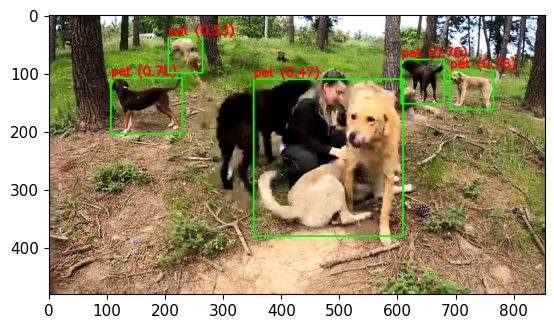

In [9]:
frame_path = frame_paths[10]

# Load the image
image = cv2.imread(frame_path)

# Preprocess the image (resize, normalize)
results = model(image)
display_detections(image, results)

In [11]:
# Create samples for your data
samples = []
for filepath in frame_paths:
    sample = fo.Sample(filepath = filepath)
    # Preprocess the image (resize, normalize)
    results = model(filepath)
    boxesn = results.pandas().xyxyn[0]
    boxesn = boxesn[boxesn['class'].isin(class_mapping.keys()) & (boxesn['confidence']>=conf_threshold)].replace({"class": class_mapping})
    boxesn = boxesn.assign(width = lambda r: r.xmax - r.xmin, height = lambda r: r.ymax - r.ymin)

    # Convert detections to FiftyOne format
    detections = []
    for i, obj in boxesn.iterrows():
        detections.append(
            fo.Detection(label = obj["class"], 
                         bounding_box = obj[['xmin', 'ymin', 'width', 'height']].tolist(), 
                         confidence = obj['confidence'], 
                         index = i)
        )

    # Store detections in a field name of your choice
    sample["ground_truth"] = fo.Detections(detections=detections)

    samples.append(sample)

# Create dataset
dataset = fo.Dataset("youtube-dataset-od")
dataset.add_samples(samples)

 100% |███████████████| 2775/2775 [7.4s elapsed, 0s remaining, 360.7 samples/s]      


['65e479a2e33dde17a104a4d8',
 '65e479a2e33dde17a104a4d9',
 '65e479a2e33dde17a104a4da',
 '65e479a2e33dde17a104a4db',
 '65e479a2e33dde17a104a4dc',
 '65e479a2e33dde17a104a4dd',
 '65e479a2e33dde17a104a4de',
 '65e479a2e33dde17a104a4df',
 '65e479a2e33dde17a104a4e0',
 '65e479a2e33dde17a104a4e1',
 '65e479a2e33dde17a104a4e2',
 '65e479a2e33dde17a104a4e3',
 '65e479a2e33dde17a104a4e4',
 '65e479a2e33dde17a104a4e5',
 '65e479a2e33dde17a104a4e6',
 '65e479a2e33dde17a104a4e7',
 '65e479a2e33dde17a104a4e8',
 '65e479a2e33dde17a104a4e9',
 '65e479a2e33dde17a104a4ea',
 '65e479a2e33dde17a104a4eb',
 '65e479a2e33dde17a104a4ec',
 '65e479a2e33dde17a104a4ed',
 '65e479a2e33dde17a104a4ee',
 '65e479a2e33dde17a104a4ef',
 '65e479a2e33dde17a104a4f0',
 '65e479a2e33dde17a104a4f1',
 '65e479a2e33dde17a104a4f2',
 '65e479a2e33dde17a104a4f3',
 '65e479a2e33dde17a104a4f4',
 '65e479a2e33dde17a104a4f5',
 '65e479a2e33dde17a104a4f6',
 '65e479a2e33dde17a104a4f7',
 '65e479a2e33dde17a104a4f8',
 '65e479a2e33dde17a104a4f9',
 '65e479a2e33d

In [44]:
dataset.persistent = True

In [45]:
dataset

Name:        youtube-dataset-od
Media type:  image
Num samples: 2775
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [14]:
session = fo.launch_app(dataset, auto = False)

Session launched. Run `session.show()` to open the App in a cell output.


In [79]:
# train/val split
four.random_split(dataset, {"train": 0.8, "val": 0.2})


In [92]:
# Exploratory analysis of data distribution in a dataset

def ds_dist_analysis(ds):
    samples_cnt = ds.count()
    labels_cnt = ds.count("ground_truth.detections.label")
    print('Samples count:', samples_cnt, '<br>')
    print('Labels count:', labels_cnt)

    dist_analysis = pd.Series(ds.count_values("ground_truth.detections.label"), name="label_counts").rename_axis("class").to_frame()
    dist_analysis["label_share"] = dist_analysis['label_counts'] / labels_cnt
    dist_analysis["samples_counts"] = pd.Series(
        {k: ds.filter_labels("ground_truth", fo.ViewField("label").is_in([k])).count()
        for k in dist_analysis.index}
        )
    dist_analysis["samples_share"] = dist_analysis["samples_counts"] / samples_cnt

    print('\nDistribution labels and samples between classes:')
    print(dist_analysis.to_markdown())

In [93]:
print("\n# Whole dataset")
ds_dist_analysis(dataset)
print("\n## Train split")
ds_dist_analysis(dataset.match_tags("train"))
print("\n## Val split")
ds_dist_analysis(dataset.match_tags("val"))


# Whole dataset
Samples count: 2775 <br>
Labels count: 21308

Distribution labels and samples between classes:
| class   |   label_counts |   label_share |   samples_counts |   samples_share |
|:--------|---------------:|--------------:|-----------------:|----------------:|
| pet     |           5687 |      0.266895 |             1173 |        0.422703 |
| car     |           4016 |      0.188474 |              867 |        0.312432 |
| person  |          11605 |      0.544631 |             1633 |        0.588468 |

## Train split
Samples count: 2220 <br>
Labels count: 17122

Distribution labels and samples between classes:
| class   |   label_counts |   label_share |   samples_counts |   samples_share |
|:--------|---------------:|--------------:|-----------------:|----------------:|
| pet     |           4676 |      0.273099 |              950 |        0.427928 |
| car     |           3171 |      0.1852   |              687 |        0.309459 |
| person  |           9275 |      0.541

In [90]:
# Export the dataset as a COCO format

dataset.export(
    export_dir = "dataset",
    dataset_type = fo.types.COCODetectionDataset,
    label_field = "ground_truth",
)

Directory 'dataset' already exists; export will be merged with existing files
 100% |███████████████| 2775/2775 [6.1s elapsed, 0s remaining, 466.8 samples/s]       
